In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import *
from train import *

# for tensorboard
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

# Using embedding
In this experiment, we sample data not only from uniform distribution but from variety of distributions. We then use this data for encoder and feed its output throught cross-attention mechanism to the decoder. The decoder takes the sequence with missing tokens and tries to fill in the gaps.

### Architecture
- We use multihead attention for the encoder and vanilla attention for the decoder.
- In the encoder, before splitting heads I "merge" the 5 sequences through linear layer.

In [2]:
import os
print(os.getcwd())

/Users/mariayuffa/semester-project


In [3]:
# Sequences for decoder
final_chains_train = np.load('data/final_chains_T=1_num_iters=400_train.npy')
chains_train = final_chains_train.copy()
chains_train[final_chains_train==-1] = 1
chains_train[final_chains_train==1] = 3
tensor_chains_train = torch.tensor(chains_train, dtype=torch.long)
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)

final_chains_test = np.load('data/final_chains_T=1_num_iters=400_test.npy')
chains_test = final_chains_test.copy()
chains_test[final_chains_test==-1] = 1 
chains_test[final_chains_test==1] = 3 
tensor_chains_test = torch.tensor(chains_test, dtype=torch.long)
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)


# Sequences for encoder
k = 0
final_chains_encoder_train = np.zeros((1000,5,200))
final_chains_encoder_train[:,0,:] = np.load('data/final_chains_T=1_num_iters=400_J=10_test.npy') 
final_chains_encoder_test = np.zeros((1000,5,200))
final_chains_encoder_test[:,0,:] = np.load('data/final_chains_T=1_num_iters=400_J=10_test.npy') 
for i in range(20,100,20):
    k+=1
    final_chains_encoder_train[:,k,:] = np.load('data/final_chains_T=1_num_iters=400_J='+str(i)+'_train.npy')
    final_chains_encoder_test[:,k,:] = np.load('data/final_chains_T=1_num_iters=400_J='+str(i)+'_test.npy') 

print("Loaded train sequences of proteins for encoder distribution:", final_chains_encoder_train.shape)
print("Loaded test sequences of proteins for encoder distribution:", final_chains_encoder_test.shape)

samples_train = final_chains_encoder_train.copy() 
samples_train[final_chains_encoder_train==-1] = 1
samples_train[final_chains_encoder_train==1] = 3
tensor_samples_train = torch.tensor(samples_train, dtype=torch.long)

samples_test = final_chains_encoder_test.copy()
samples_test[final_chains_encoder_test==-1] = 1
samples_test[final_chains_encoder_test==1] = 3
tensor_samples_test = torch.tensor(samples_test, dtype=torch.long)

Loaded train sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded test sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded train sequences of proteins for encoder distribution: (1000, 5, 200)
Loaded test sequences of proteins for encoder distribution: (1000, 5, 200)


In [4]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout, num_distr=5):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(num_spins+1, embed_dim)
        self.decoder_embedding = nn.Embedding(num_spins+1, embed_dim)

        #self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        #self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.encoder_layer = EncoderLayer(embed_dim, proj_layer_dim, dropout, num_distr)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.fc = nn.Linear(embed_dim, num_spins)

    def forward(self, src, tgt):
        #src_mask, tgt_mask = self.generate_mask(src, tgt)
        #src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        #tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        src_embedded = self.positional_encoding(self.encoder_embedding(src))
        tgt_embedded = self.positional_encoding(self.decoder_embedding(tgt))
        enc_output = self.encoder_layer(src_embedded)
        dec_output = self.decoder_layer(tgt_embedded, enc_output)
        output = self.fc(dec_output)
        #print("output of the transformer:", output.shape)
        return output
    
    def get_cross_attention_weights(self):
        return self.decoder_layer.cross_attn_weights

## Training and validation

In [5]:
# Define the parameters 
vocab_size = 3
vocab = {1:0,3:1,2:2} 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-3
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [6]:
# Example usage:

model = Transformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

#train(model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
path = 'runs/embedding_run_5_(1,3)'
training_script(path, model, data_train=tensor_samples_train, data_train_dec=tensor_chains_train,
                data_test=tensor_samples_test, data_test_dec=tensor_chains_test, vocab=vocab, optimizer=optimizer,
                criterion=criterion, one_hot_flag=False, num_epochs=15, device=0)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/15 [00:00<?, ?it/s]/Users/mariayuffa/semester-project/train.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_enc = torch.tensor(input_seq_enc, dtype=torch.long)
100%|██████████| 1000/1000 [00:08<00:00, 117.66it/s]


Epoch 1 | Train Loss: 143.0338


  7%|▋         | 1/15 [00:11<02:36, 11.15s/it]

Epoch 1 | Eval Loss: 0.6982


100%|██████████| 1000/1000 [00:08<00:00, 119.82it/s]


Epoch 2 | Train Loss: 139.6123


 13%|█▎        | 2/15 [00:21<02:21, 10.90s/it]

Epoch 2 | Eval Loss: 0.6935


100%|██████████| 1000/1000 [00:07<00:00, 135.15it/s]


Epoch 3 | Train Loss: 139.1195


 20%|██        | 3/15 [00:31<02:04, 10.39s/it]

Epoch 3 | Eval Loss: 0.6932


100%|██████████| 1000/1000 [00:07<00:00, 132.15it/s]


Epoch 4 | Train Loss: 138.8591


 27%|██▋       | 4/15 [00:41<01:52, 10.24s/it]

Epoch 4 | Eval Loss: 0.6930


100%|██████████| 1000/1000 [00:07<00:00, 132.58it/s]


Epoch 5 | Train Loss: 139.7843


 33%|███▎      | 5/15 [00:51<01:41, 10.16s/it]

Epoch 5 | Eval Loss: 0.6928


100%|██████████| 1000/1000 [00:07<00:00, 125.44it/s]


Epoch 6 | Train Loss: 138.9065


 40%|████      | 6/15 [01:02<01:32, 10.32s/it]

Epoch 6 | Eval Loss: 0.6926


100%|██████████| 1000/1000 [00:07<00:00, 128.97it/s]


Epoch 7 | Train Loss: 139.0574


 47%|████▋     | 7/15 [01:12<01:22, 10.36s/it]

Epoch 7 | Eval Loss: 0.6929


100%|██████████| 1000/1000 [00:09<00:00, 110.10it/s]


Epoch 8 | Train Loss: 138.8487


 53%|█████▎    | 8/15 [01:24<01:14, 10.71s/it]

Epoch 8 | Eval Loss: 0.6925


100%|██████████| 1000/1000 [00:08<00:00, 120.12it/s]


Epoch 9 | Train Loss: 138.9358


 60%|██████    | 9/15 [01:34<01:04, 10.68s/it]

Epoch 9 | Eval Loss: 0.6926


100%|██████████| 1000/1000 [00:07<00:00, 135.27it/s]


Epoch 10 | Train Loss: 138.8413


 67%|██████▋   | 10/15 [01:44<00:51, 10.38s/it]

Epoch 10 | Eval Loss: 0.6926


100%|██████████| 1000/1000 [00:07<00:00, 127.48it/s]


Epoch 11 | Train Loss: 138.7605


 73%|███████▎  | 11/15 [01:54<00:41, 10.26s/it]

Epoch 11 | Eval Loss: 0.6926


100%|██████████| 1000/1000 [00:08<00:00, 115.71it/s]


Epoch 12 | Train Loss: 138.9600


 80%|████████  | 12/15 [02:05<00:31, 10.57s/it]

Epoch 12 | Eval Loss: 0.6926


100%|██████████| 1000/1000 [00:09<00:00, 103.39it/s]


Epoch 13 | Train Loss: 138.8312


 87%|████████▋ | 13/15 [02:18<00:22, 11.13s/it]

Epoch 13 | Eval Loss: 0.6925


100%|██████████| 1000/1000 [00:09<00:00, 108.17it/s]


Epoch 14 | Train Loss: 138.7116


 93%|█████████▎| 14/15 [02:30<00:11, 11.35s/it]

Epoch 14 | Eval Loss: 0.6922


100%|██████████| 1000/1000 [00:09<00:00, 104.40it/s]


Epoch 15 | Train Loss: 138.7790


100%|██████████| 1000/1000 [00:02<00:00, 366.89it/s]
                                               

Epoch 15 | Eval Loss: 0.6928


In [ ]:
cross_attention_weights = model.get_cross_attention_weights()
print("Cross-attention weights:", cross_attention_weights)

NameError: name 'model' is not defined

In [ ]:
# To save only the decoder layer weights
torch.save(model.decoder_layer.state_dict(), 'model_decoder/decoder_weights.pth')
torch.save(model.get_cross_attention_weights(), 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/decoder_weights.pth')
model.decoder_layer.load_state_dict(decoder_weights)

# Save the weights of the FC layer
torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights.pth')

# To load these weights back into the FC layer later
fc_weights = torch.load('model_decoder/transformer_fc_weights.pth')
model.fc.load_state_dict(fc_weights)

NameError: name 'model' is not defined

# Ablation study
In this study we remove the encoder when testing the model

In [ ]:
class TransformerAblated(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout):
        super(TransformerAblated, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins+1, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.fc = nn.Linear(embed_dim, num_spins)

    def forward(self, tgt):
        tgt_embedded = self.word_embeddings(tgt)
        dec_output = self.decoder_layer(tgt_embedded, tgt_embedded)
        output = self.fc(dec_output)
        return output

In [ ]:
# Create an instance of the new model
new_model = TransformerAblated(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)

# Load the saved decoder weights
decoder_weights = torch.load('model_decoder/decoder_weights.pth')
new_model.decoder_layer.load_state_dict(decoder_weights)

# Load the saved FC weights
fc_weights = torch.load('model_decoder/transformer_fc_weights.pth')
new_model.fc.load_state_dict(fc_weights)


<All keys matched successfully>

In [ ]:
writer = SummaryWriter('runs/transformer_ablation_encoding_run_3')

def evaluate(new_model, data_test, data_test_dec, vocab, criterion, device=0):
    new_model.eval()
    model.eval()
    epoch_loss = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    for i, data in tqdm.tqdm(enumerate(data_test), total=len(data_test)):
        # Get the inputs
        input_seq_dec = data_test_dec[i]
        # mask a token
        masked_sequence_dec, positions = mask_random_spins(input_seq_dec, vocab, mask_token=2)
        
        # Forward pass
        outputs = new_model.forward(masked_sequence_dec)

        #output_token = F.log_softmax(outputs, dim=-1)
        target_tokens = input_seq_dec[positions] #input_seq[masked_position]
        target_tokens = torch.tensor([vocab[int(token)] for token in target_tokens], dtype=torch.long)

        # Compute loss
        loss = criterion(outputs[positions], target_tokens)
        epoch_loss += loss.item()

    return epoch_loss / len(data_test)

def train(model, new_model, data_train, data_train_dec, data_test, data_test_dec, vocab, optimizer, criterion, num_epochs=20, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        
        for i, data in tqdm.tqdm(enumerate(data_train), total=len(data_train)):            
            # Get the inputs
            input_seq_enc = torch.tensor(data, dtype=torch.long)
            input_seq_dec = data_train_dec[i]

            # mask a token in decoder
            masked_sequence_dec, positions = mask_random_spins(input_seq_dec, vocab, mask_token=2)

            # Forward pass
            predictions = model.forward(input_seq_enc, masked_sequence_dec) #masked_sequence[masked_position]
            
            #predicted_token = F.log_softmax(prediction, dim=-1)
            target_tokens = input_seq_dec[positions] #input_seq[masked_position]
            target_tokens = torch.tensor([vocab[int(token)] for token in target_tokens], dtype=torch.long)
            
            # Compute loss
            #print("model prediction:", prediction.shape)
            #print("target:", target_token.shape)
            loss = criterion(predictions[positions], target_tokens)
            epoch_loss += loss.item()
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 10 == 9. :    # print every 10 mini-batches
                writer.add_scalar("Running Loss", running_loss / 100, epoch)
                #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        new_model.decoder_layer = model.decoder_layer
        new_model.fc = model.fc
        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data)):.4f}')
        writer.add_scalar("Train Loss", epoch_loss / len(data), epoch)
        eval_loss = evaluate(new_model, data_test, data_test_dec, vocab, criterion, device=device)
        writer.add_scalar("Eval Loss", eval_loss, epoch)
        print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
        if eval_loss < best_eval_loss:
            return epoch_loss / len(data_train)
    return epoch_loss / len(data_train)

writer.flush()
writer.close()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
vocab = {1:0,3:1,2:2}

# Define the parameters 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-2
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

train(model, new_model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)


mps


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_79964/6391302.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_enc = torch.tensor(data, dtype=torch.long)
100%|██████████| 1000/1000 [00:10<00:00, 93.69it/s]


Epoch 1 | Train Loss: 138.9897


  5%|▌         | 1/20 [00:12<03:56, 12.47s/it]

Epoch 1 | Eval Loss: 0.7200


100%|██████████| 1000/1000 [00:12<00:00, 80.35it/s]


Epoch 2 | Train Loss: 138.8400


 10%|█         | 2/20 [00:26<04:02, 13.48s/it]

Epoch 2 | Eval Loss: 0.6919


100%|██████████| 1000/1000 [00:11<00:00, 89.98it/s]


Epoch 3 | Train Loss: 138.7037


 15%|█▌        | 3/20 [00:39<03:46, 13.32s/it]

Epoch 3 | Eval Loss: 0.6927


100%|██████████| 1000/1000 [00:10<00:00, 96.58it/s]


Epoch 4 | Train Loss: 138.7593


 20%|██        | 4/20 [00:51<03:24, 12.76s/it]

Epoch 4 | Eval Loss: 0.6925


100%|██████████| 1000/1000 [00:10<00:00, 93.63it/s] 


Epoch 5 | Train Loss: 138.6561


 25%|██▌       | 5/20 [01:04<03:09, 12.63s/it]

Epoch 5 | Eval Loss: 0.6924


100%|██████████| 1000/1000 [00:10<00:00, 95.63it/s]


Epoch 6 | Train Loss: 138.7184


 30%|███       | 6/20 [01:16<02:57, 12.65s/it]

Epoch 6 | Eval Loss: 0.6921


100%|██████████| 1000/1000 [00:11<00:00, 85.35it/s]


Epoch 7 | Train Loss: 138.7453


 35%|███▌      | 7/20 [01:30<02:47, 12.86s/it]

Epoch 7 | Eval Loss: 0.6923


100%|██████████| 1000/1000 [00:11<00:00, 87.90it/s]


Epoch 8 | Train Loss: 138.7191


 40%|████      | 8/20 [01:43<02:36, 13.02s/it]

Epoch 8 | Eval Loss: 0.6925


100%|██████████| 1000/1000 [00:11<00:00, 86.89it/s]


Epoch 9 | Train Loss: 138.6193


 45%|████▌     | 9/20 [01:56<02:23, 13.09s/it]

Epoch 9 | Eval Loss: 0.6914


100%|██████████| 1000/1000 [00:10<00:00, 95.94it/s]


Epoch 10 | Train Loss: 138.7944


 50%|█████     | 10/20 [02:09<02:09, 12.93s/it]

Epoch 10 | Eval Loss: 0.6926


100%|██████████| 1000/1000 [00:12<00:00, 81.31it/s]


Epoch 11 | Train Loss: 138.7810


 55%|█████▌    | 11/20 [02:23<02:00, 13.37s/it]

Epoch 11 | Eval Loss: 0.6922


100%|██████████| 1000/1000 [00:12<00:00, 79.80it/s]


Epoch 12 | Train Loss: 138.6625


 60%|██████    | 12/20 [02:37<01:48, 13.53s/it]

Epoch 12 | Eval Loss: 0.6921


100%|██████████| 1000/1000 [00:11<00:00, 84.51it/s]


Epoch 13 | Train Loss: 138.8257


 65%|██████▌   | 13/20 [02:51<01:35, 13.59s/it]

Epoch 13 | Eval Loss: 0.6924


100%|██████████| 1000/1000 [00:11<00:00, 88.86it/s]


Epoch 14 | Train Loss: 138.6698


 70%|███████   | 14/20 [03:04<01:21, 13.55s/it]

Epoch 14 | Eval Loss: 0.6926


100%|██████████| 1000/1000 [00:10<00:00, 91.60it/s]


Epoch 15 | Train Loss: 138.7148


 75%|███████▌  | 15/20 [03:17<01:06, 13.33s/it]

Epoch 15 | Eval Loss: 0.6925


100%|██████████| 1000/1000 [00:10<00:00, 91.16it/s]


Epoch 16 | Train Loss: 138.7301


 80%|████████  | 16/20 [03:30<00:53, 13.32s/it]

Epoch 16 | Eval Loss: 0.6921


100%|██████████| 1000/1000 [00:13<00:00, 76.18it/s]


Epoch 17 | Train Loss: 138.6989


 85%|████████▌ | 17/20 [03:46<00:42, 14.04s/it]

Epoch 17 | Eval Loss: 0.6922


100%|██████████| 1000/1000 [00:13<00:00, 72.14it/s]


Epoch 18 | Train Loss: 138.6857


 90%|█████████ | 18/20 [04:02<00:29, 14.67s/it]

Epoch 18 | Eval Loss: 0.6920


100%|██████████| 1000/1000 [00:12<00:00, 82.76it/s]


Epoch 19 | Train Loss: 138.6768


 95%|█████████▌| 19/20 [04:17<00:14, 14.61s/it]

Epoch 19 | Eval Loss: 0.6927


100%|██████████| 1000/1000 [00:12<00:00, 80.31it/s]


Epoch 20 | Train Loss: 138.7539


100%|██████████| 1000/1000 [00:02<00:00, 476.28it/s]
                                               

Epoch 20 | Eval Loss: 0.6927


0.6937693859934807

# Extracting activations

In [ ]:
tensor_chains_test.shape

torch.Size([1000, 200])

Cross-attention weights: torch.Size([200, 200])


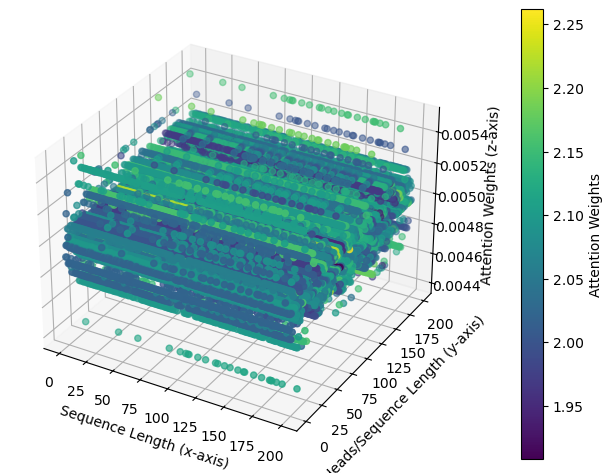

In [ ]:
# loading self-attention weights
cross_attention_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print("Cross-attention weights:", cross_attention_weights.shape)
#model.decoder_layer.load_state_dict(cross_attention_weights)
caw = cross_attention_weights.cpu().detach().numpy()

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Transpose the meshgrid to match the shape of attention_weights
x = x.T
y = y.T

# Flatten the x, y, and z (attention_weights) for plotting
x = x.flatten()
y = y.flatten()
z = caw.flatten()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap
# third distribution is more aligned one
sc = ax.scatter(x, y, z, c=np.dot(caw,tensor_samples_test[:200,2,:]), cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Attention Weights')

# Labels
ax.set_xlabel('Sequence Length (x-axis)')
ax.set_ylabel('Heads/Sequence Length (y-axis)')
ax.set_zlabel('Attention Weights (z-axis)')


plt.tight_layout()
plt.show()


### need to think what to do with them